# Plant Disease Data EDA

---

In [ ]:
#! git clone https://github.com/digitalepidemiologylab/plantvillage_deeplearning_paper_dataset.git


In [2]:
import os
import sys
import time
import re
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

#import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, PReLU
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
#from keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers

import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

sns.set_palette('muted',color_codes=True)
sns.set_context('notebook', font_scale=1.4)
vc_color = '#B5C9EB'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/My Drive/research_practice/plant_diseases/notebooks"
os.getcwd()

In [3]:
# Path variables
#data_dir = "../data/raw/plant_diseases/color/original/"
#/content/drive/MyDrive/research_practice/plant_diseases
data_dir = "../data/color/original"

# Get list of all classes
classes = os.listdir(data_dir)
set(classes)

{'Apple___apple_scab',
 'Apple___black_rot',
 'Apple___cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry___healthy',
 'Cherry___powdery_mildew',
 'Corn___common_rust',
 'Corn___gray_leaf_spot',
 'Corn___healthy',
 'Corn___northern_leaf_blight',
 'Grape___black_measels',
 'Grape___black_rot',
 'Grape___healthy',
 'Grape___leaf_blight',
 'Orange___citrus_greening',
 'Peach___bacterial_spot',
 'Peach___healthy',
 'Pepper_bell___bacterial_spot',
 'Pepper_bell___healthy',
 'Potato___early_blight',
 'Potato___healthy',
 'Potato___late_blight',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___powdery_mildew',
 'Strawberry___healthy',
 'Strawberry___leaf_scorch',
 'Tomato___bacterial_spot',
 'Tomato___early_blight',
 'Tomato___healthy',
 'Tomato___late_blight',
 'Tomato___leaf_mold',
 'Tomato___leaf_spot',
 'Tomato___mosaic_virus',
 'Tomato___spider_mites',
 'Tomato___target_spot',
 'Tomato___yellow_leaf_curl_virus'}

In [4]:
# List of species
species = set()
for c in classes:
    s = re.findall(".+?___", c)[0][:-3]
    species.add(s)
species

{'Apple',
 'Blueberry',
 'Cherry',
 'Corn',
 'Grape',
 'Orange',
 'Peach',
 'Pepper_bell',
 'Potato',
 'Raspberry',
 'Soybean',
 'Squash',
 'Strawberry',
 'Tomato'}

In [5]:
# List of diseases
diseases = set()
for c in classes:
    d = re.findall("___.+", c)[0][3:]
    diseases.add(d)
diseases

{'apple_scab',
 'bacterial_spot',
 'black_measels',
 'black_rot',
 'cedar_apple_rust',
 'citrus_greening',
 'common_rust',
 'early_blight',
 'gray_leaf_spot',
 'healthy',
 'late_blight',
 'leaf_blight',
 'leaf_mold',
 'leaf_scorch',
 'leaf_spot',
 'mosaic_virus',
 'northern_leaf_blight',
 'powdery_mildew',
 'spider_mites',
 'target_spot',
 'yellow_leaf_curl_virus'}

In [6]:
# Look at specie, disease combinations
combined = []
for d in diseases:
    for s in species:
        name = s + "___" + d
        if name in classes:
            out = (d, s, 1)
        else:
            out = (d, s, 0)
        combined.append(out)
combined = pd.DataFrame(combined)
combined.columns = ['disease', 'specie', 'flag']
combined.pivot_table(values='flag', index='disease', columns='specie')

specie                  Apple  Blueberry  Cherry  Corn  Grape  Orange  Peach  \
disease                                                                        
apple_scab                  1          0       0     0      0       0      0   
bacterial_spot              0          0       0     0      0       0      1   
black_measels               0          0       0     0      1       0      0   
black_rot                   1          0       0     0      1       0      0   
cedar_apple_rust            1          0       0     0      0       0      0   
citrus_greening             0          0       0     0      0       1      0   
common_rust                 0          0       0     1      0       0      0   
early_blight                0          0       0     0      0       0      0   
gray_leaf_spot              0          0       0     1      0       0      0   
healthy                     1          1       1     1      1       0      1   
late_blight                 0          0       0     0      0       0      0   
leaf_blight                 0          0       0     0      1       0      0   
leaf_mold                   0          0       0     0      0       0      0   
leaf_scorch                 0          0       0     0      0       0      0   
leaf_spot                   0          0       0     0      0       0      0   
mosaic_virus                0          0       0     0      0       0      0   
northern_leaf_blight        0          0       0     1      0       0      0   
powdery_mildew              0          0       1     0      0       0      0   
spider_mites                0          0       0     0      0       0      0   
target_spot                 0          0       0     0      0       0      0   
yellow_leaf_curl_virus      0          0       0     0      0       0      0   

specie                  Pepper_bell  Potato  Raspberry  Soybean  Squash  \
disease                                                                   
apple_scab                        0       0          0        0       0   
bacterial_spot                    1       0          0        0       0   
black_measels                     0       0          0        0       0   
black_rot                         0       0          0        0       0   
cedar_apple_rust                  0       0          0        0       0   
citrus_greening                   0       0          0        0       0   
common_rust                       0       0          0        0       0   
early_blight                      0       1          0        0       0   
gray_leaf_spot                    0       0          0        0       0   
healthy                           1       1          1        1       0   
late_blight                       0       1          0        0       0   
leaf_blight                       0       0          0        0       0   
leaf_mold                         0       0          0        0       0   
leaf_scorch                       0       0          0        0       0   
leaf_spot                         0       0          0        0       0   
mosaic_virus                      0       0          0        0       0   
northern_leaf_blight              0       0          0        0       0   
powdery_mildew                    0       0          0        0       1   
spider_mites                      0       0          0        0       0   
target_spot                       0       0          0        0       0   
yellow_leaf_curl_virus            0       0          0        0       0   

specie                  Strawberry  Tomato  
disease                                     
apple_scab                       0       0  
bacterial_spot                   0       1  
black_measels                    0       0  
black_rot                        0       0  
cedar_apple_rust                 0       0  
citrus_greening                  0       0  
common_rust                      0       0  
early_blight                

In [7]:
# Number of images in each class
image_counts = {}
for c in classes:
    path = data_dir + "/" +c
    count = len(os.listdir(path))
    image_counts[c] = count
pd.DataFrame.from_dict(image_counts, orient='index')

0
Tomato___late_blight             1909
Blueberry___healthy              1502
Corn___gray_leaf_spot             513
Tomato___leaf_mold                952
Corn___healthy                   1162
Tomato___leaf_spot               1771
Grape___black_rot                1180
Grape___leaf_blight              1076
Soybean___healthy                5090
Orange___citrus_greening         5507
Corn___common_rust               1192
Peach___healthy                   360
Tomato___yellow_leaf_curl_virus  5357
Tomato___mosaic_virus             373
Potato___early_blight            1000
Grape___black_measels            1383
Cherry___healthy                  854
Pepper_bell___bacterial_spot      997
Apple___healthy                  1645
Squash___powdery_mildew          1835
Apple___cedar_apple_rust          275
Corn___northern_leaf_blight       985
Pepper_bell___healthy            1478
Raspberry___healthy               371
Apple___black_rot                 621
Tomato___healthy                 1591
Tomato___bacterial_spot          2127
Potato___healthy                  152
Strawberry___leaf_scorch         1109
Tomato___early_blight            1000
Peach___bacterial_spot           2297
Tomato___spider_mites            1676
Tomato___target_spot             1404
Cherry___powdery_mildew          1052
Grape___healthy                   423
Apple___apple_scab                630
Strawberry___healthy              456
Potato___late_blight             1000

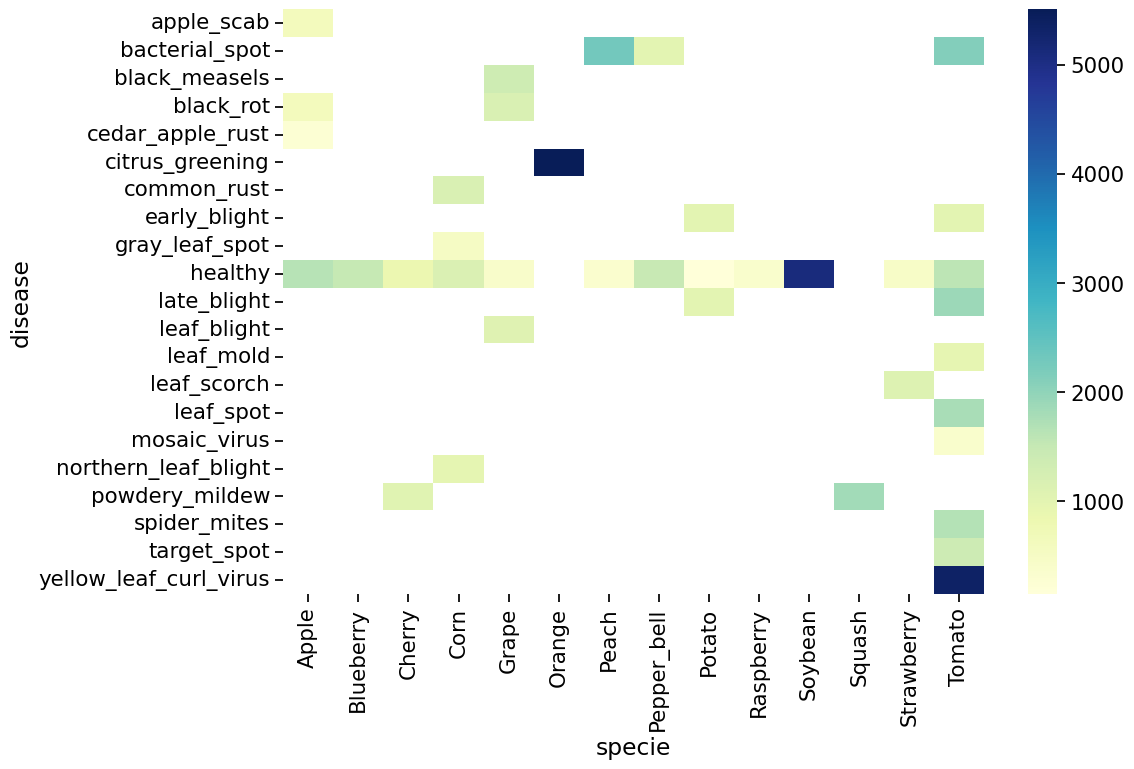

In [8]:
# Look at specie, disease combinations
combined = []
for d in diseases:
    for s in species:
        name = s + "___" + d
        if name in classes:
            path = data_dir + '/' +name
            count = len(os.listdir(path))
            out = (d, s, count)
        else:
            out = (d, s, 0)
        combined.append(out)
combined = pd.DataFrame(combined)
combined.columns = ['disease', 'specie', 'flag']
hm = combined.pivot_table(values='flag', index='disease', columns='specie')

plt.figure(figsize=(12, 8))
msk = hm == 0
sns.heatmap(hm, cmap="YlGnBu", mask=msk);
plt.tight_layout()
plt.savefig("./images/specie_disease_heatmap.png")

In [9]:
print(f"Total number of images: {sum(image_counts.values())}")

Total number of images: 54305


In [10]:
# Get path and label for each training image
db=[]
for label, class_name in enumerate(classes):
    path = os.path.join(data_dir,class_name)
    #print(path)
    for file in os.listdir(path):
        if not '.ini' in file:
            db.append(['{}/{}'.format(class_name, file), label, class_name])
db = pd.DataFrame(db, columns=['file', 'label', 'class_name'])
db

file  label  \
0      Tomato___late_blight/eda41abe-61cf-439d-9562-e...      0   
1      Tomato___late_blight/f2c089b3-34a5-4300-848f-a...      0   
2      Tomato___late_blight/8bae80d9-576c-4930-8c75-f...      0   
3      Tomato___late_blight/def2ded7-c610-404f-909f-8...      0   
4      Tomato___late_blight/be5c294b-38cc-44b8-b404-a...      0   
...                                                  ...    ...   
54300  Potato___late_blight/64fd9d16-28df-4dd7-9bb5-9...     37   
54301  Potato___late_blight/f27d1c83-25e9-4ab8-8970-3...     37   
54302  Potato___late_blight/49835c13-105d-4afb-95dd-b...     37   
54303  Potato___late_blight/54ed9ec4-c9db-46ff-9a9b-1...     37   
54304  Potato___late_blight/53b09253-988e-4a22-966c-b...     37   

                 class_name  
0      Tomato___late_blight  
1      Tomato___late_blight  
2      Tomato___late_blight  
3      Tomato___late_blight  
4      Tomato___late_blight  
...                     ...  
54300  Potato___late_blight  
54301  Potato___late_blight  
54302  Potato___late_blight  
54303  Potato___late_blight  
54304  Potato___late_blight  

[54305 rows x 3 columns]

In [11]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir,filepath), target_size=size)
    img = image.img_to_array(img)
    return img

def format_name(s):
    return re.sub('_+', ' ', s)

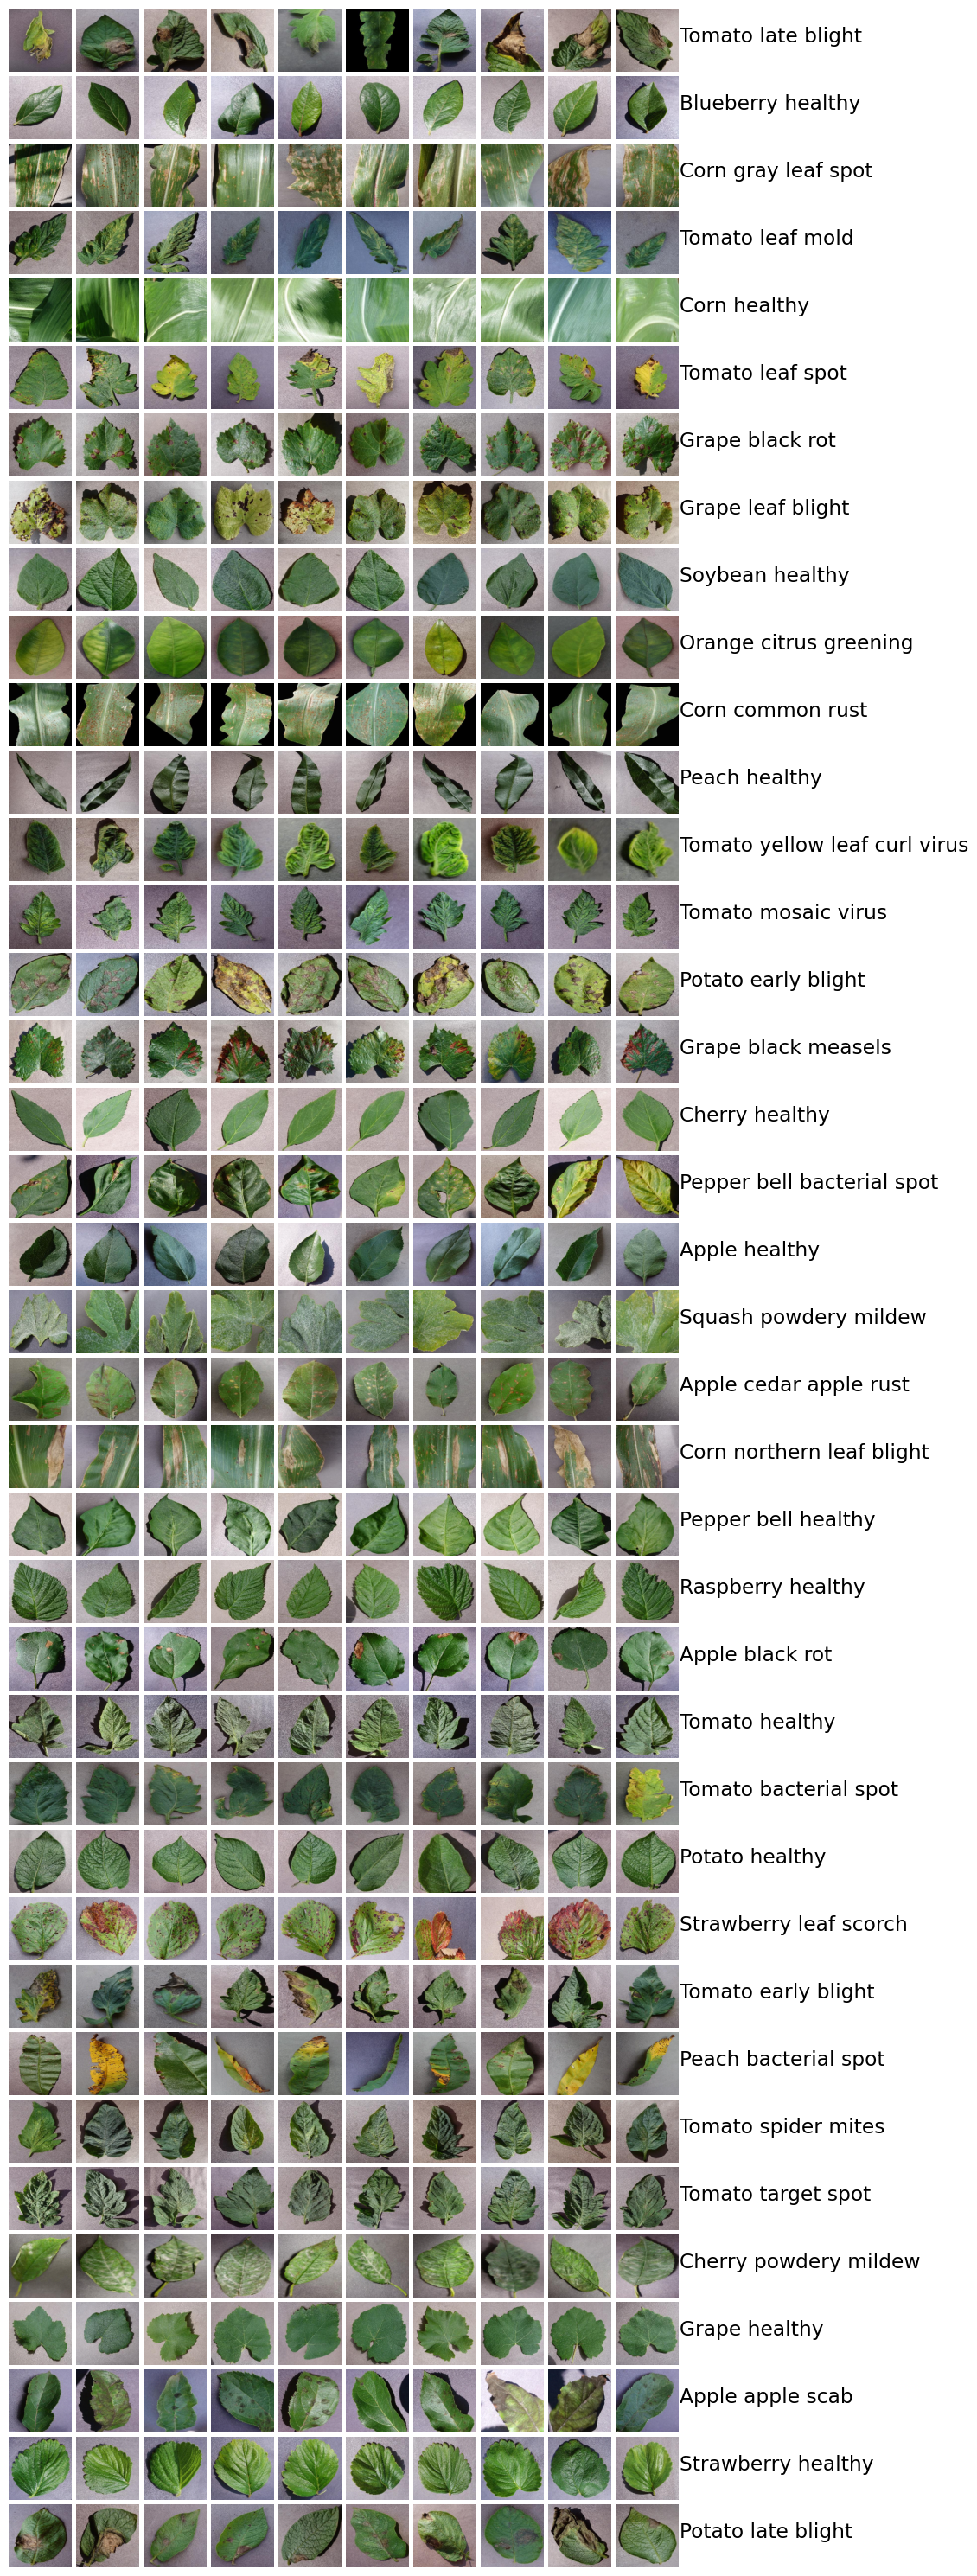

In [12]:
# Plot some images (fixed dimensions)
num_classes = len(classes)
fig = plt.figure(1, figsize=(10, 40))
grid = ImageGrid(fig, 111, nrows_ncols=(num_classes, 10), axes_pad=0.05)

i = 0
for label, class_name in enumerate(classes):
    for filepath in db[db['class_name'] == class_name]['file'].values[:10]:
        #print(filepath)
        ax = grid[i]
        img = read_img(filepath, (256, 256))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % 10 == 10 - 1:
            name = format_name(filepath.split('/')[0])
            ax.text(260, 112, name , verticalalignment='center')
        i += 1
        
plt.show();

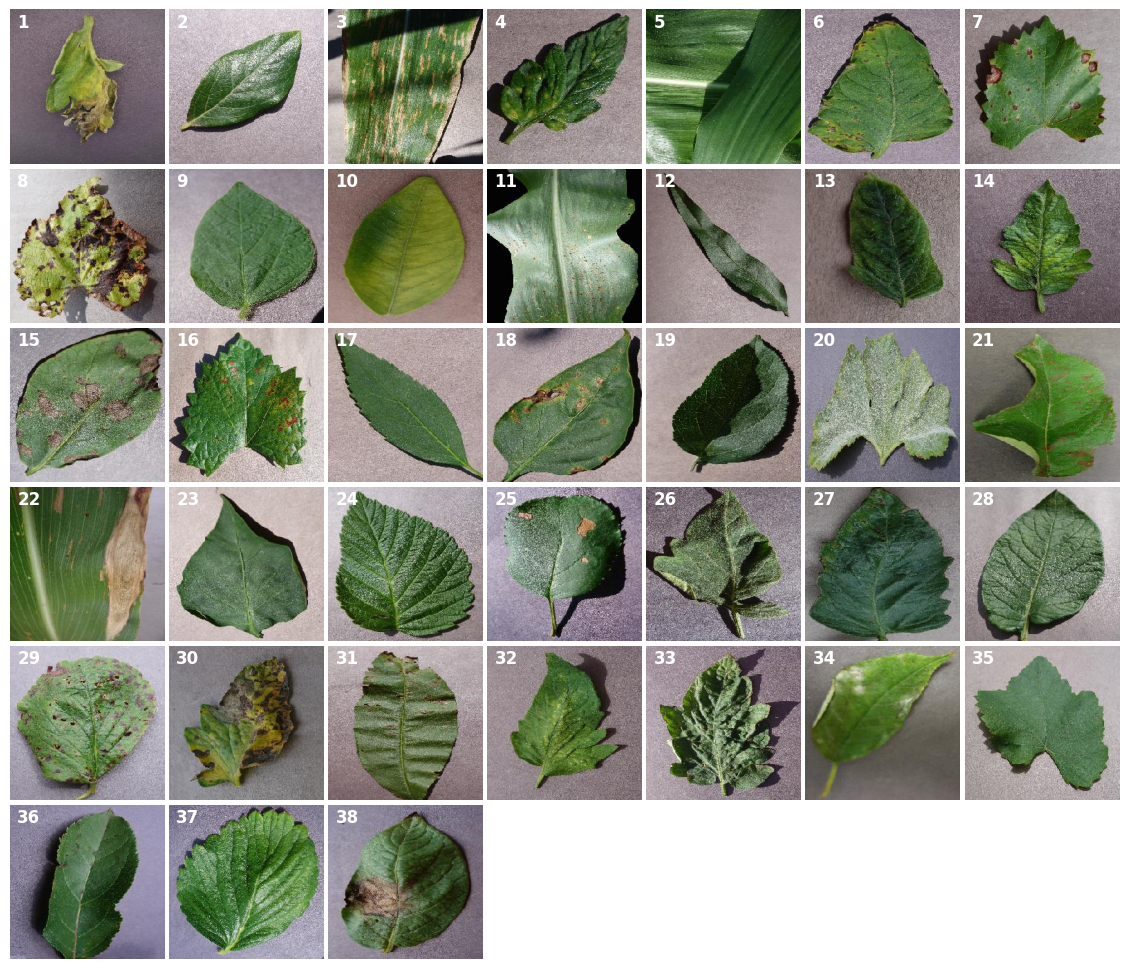

In [13]:
# Plot image from each class
fig = plt.figure(1, figsize=(15, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 7), axes_pad=0.05)

for i in range(42):
    ax = grid[i]
    ax.axis('off')
    if i < len(classes):
        class_name = classes[i]
        for filepath in db[db['class_name'] == class_name]['file'].values[:1]:
            img = read_img(filepath, (224, 224))
            ax.imshow(img / 255.)
            ax.annotate(i+1, xy=(10,25), color="white", fontsize=12, fontweight='bold')
plt.tight_layout();
plt.savefig("./images/image_per_specie.png")

../data/color/original/Tomato___yellow_leaf_curl_virus/c7e59e8b-80a7-44db-b8ff-626ffaf9edd4___YLCV_GCREC 2875.JPG
../data/grayscale/original/Tomato___yellow_leaf_curl_virus/c7e59e8b-80a7-44db-b8ff-626ffaf9edd4___YLCV_GCREC 2875.JPG
../data/segmented/original/Tomato___yellow_leaf_curl_virus/c7e59e8b-80a7-44db-b8ff-626ffaf9edd4___YLCV_GCREC 2875.JPG
../data/color/original/Blueberry___healthy/d4f37e70-e7c0-4cc4-9413-76995c60b995___RS_HL 5008.JPG
../data/grayscale/original/Blueberry___healthy/d4f37e70-e7c0-4cc4-9413-76995c60b995___RS_HL 5008.JPG
../data/segmented/original/Blueberry___healthy/d4f37e70-e7c0-4cc4-9413-76995c60b995___RS_HL 5008.JPG
../data/color/original/Raspberry___healthy/1c688d4a-786d-4c6b-a4e0-92c6d489766d___Mary_HL 9133.JPG
../data/grayscale/original/Raspberry___healthy/1c688d4a-786d-4c6b-a4e0-92c6d489766d___Mary_HL 9133.JPG
../data/segmented/original/Raspberry___healthy/1c688d4a-786d-4c6b-a4e0-92c6d489766d___Mary_HL 9133.JPG


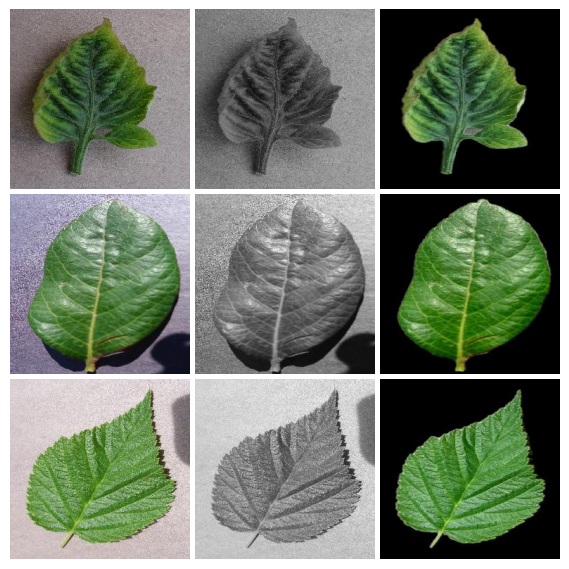

In [19]:
#data_dir = "/content/drive/MyDrive/research_practice/plant_diseases/data/raw/"
data_dir = "../data/"
fig = plt.figure(1, figsize=(6, 6))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)

np.random.seed(33)
rnd = np.random.randint(0, len(db), 3)
image_types = ["color/original", "grayscale/original", "segmented/original"]
i = 0
for r in rnd:
    file = db.file[r]
    for t in image_types:
        filepath = os.path.join(data_dir,t,file)
        print(filepath)
        if t == "segmented/original":
            filepath = filepath.replace(".JPG", "") + "_final_masked.jpg"
            
        ax = grid[i]
        img = image.load_img(filepath, target_size=(256, 256))
        img = image.img_to_array(img)
        ax.imshow(img / 255.)
        ax.axis('off')
        i += 1
plt.tight_layout()
plt.savefig("./images/image_types.png")